# Stochastic LQR Demo - A Drone in the Wind
We augment our simple planar drone model with a wind model in which the wind is a first order low pass filter with a zero-mean gaussian input. We augment the state of our quadrotor with this modeled wind state and proceed to do LQR while ignoring the wind model.

## LQR while ignoring the wind:

In [ ]:
import numpy as np
from scipy.optimize import approx_fprime
import cvxpy as cp
import control

g = 9.81  # m/s^2
m = 1.0   # kg
ℓ = 0.3   # meters
J = 0.2 * m * ℓ * ℓ
wind_speed = 5.0

h = 0.05  # time step (20 Hz)

def quad_dynamics(x, u, v=np.zeros((2,))):
    θ = x[2]
    w = x[-2:] # wind state
    dw = 2 * (wind_speed * v - w) # first order low pass filter with random noise as input for wind velocity
    x_ddot = (1/m) * (u[0] + u[1]) * np.sin(θ) + w[0]
    y_ddot = (1/m) * (u[0] + u[1]) * np.cos(θ) - g + w[1]
    θ_ddot = (1/J) * (ℓ/2) * (u[1] - u[0])
    
    return np.array([x[3], x[4], x[5], x_ddot, y_ddot, θ_ddot, dw[0], dw[1]])

def quad_dynamics_rk4(x, u, v=np.zeros((2,))):
    # RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u, v)
    f2 = quad_dynamics(x + 0.5 * h * f1, u, v)
    f3 = quad_dynamics(x + 0.5 * h * f2, u, v)
    f4 = quad_dynamics(x + h * f3, u, v)
    
    return x + (h / 6.0) * (f1 + 2*f2 + 2*f3 + f4)

# Linearized dynamics for hovering
x_hover = np.zeros(8)
u_hover = np.array([0.5 * m * g, 0.5 * m * g])
v = np.zeros((2,))
print(quad_dynamics(x_hover, u_hover))
def A_func(x):
    return quad_dynamics_rk4(x, u_hover)

def B_func(u):
    return quad_dynamics_rk4(x_hover, u)

A = approx_fprime(x_hover, A_func, np.sqrt(np.finfo(float).eps))[:6,:6]
B = approx_fprime(u_hover, B_func, np.sqrt(np.finfo(float).eps))[:6,:6]

# Time settings
Nx = 6  # number of states
Nu = 2  # number of controls
Tfinal = 15.0  # final time
Nt = int(Tfinal / h) + 1  # number of time steps
thist = np.arange(0, h * (Nt - 1) + h, step=h)

# Cost weights
Q = np.eye(Nx)
Q[2,2] = 100.0
R = 0.01 * np.eye(Nu)

# LQR Hover Controller
K, P, E = control.dlqr(A, B, Q, R)

def lqr_controller(t, x, K, xref):
    return u_hover - K @ (x - xref)

def cost(xhist, uhist, x_ref, Q, R):
    cost_val = 0.5 * (xhist[:, -1].T - x_ref) @ Q @ (xhist[:, -1] - x_ref)
    for k in range(xhist.shape[1] - 1):
        # print(xhist[:, k].T - x_ref)
        cost_val += 0.5 * (xhist[:, k].T - x_ref) @ Q @ (xhist[:, k] - x_ref) + 0.5 * (uhist[:,k].T @ R @ uhist[:,k])
    print("Total Cost: ", cost_val)
    return cost_val

# Closed-loop simulation
def closed_loop(x0, controller, N):
    xhist = np.zeros((len(x0), N))
    u0 = controller(0, x0[:6])
    uhist = np.zeros((len(u0), N-1))
    uhist[:, 0] = u0
    xhist[:, 0] = x0
    
    for k in range(N-1):
        v = np.random.normal(0, 1, 2)
        uk = controller(k, xhist[:6, k])
        uhist[:, k] = uk #np.clip(uk, umin, umax)  # enforce control limits
        xhist[:, k+1] = quad_dynamics_rk4(xhist[:, k], uhist[:, k], v)
    
    return xhist, uhist

[0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
# Reference and initial state
x_ref = np.array([0.0, 1.0, 0, 0, 0, 0])
x0 = np.array([10.0, 2.0, 0.0, 0, 0, 0, 0, 0])

# Simulate closed-loop responses
xhist1, uhist1 = closed_loop(x0, lambda t, x: lqr_controller(t, x, K, x_ref), Nt)
# xhist2, uhist2 = closed_loop(x0, lambda t, x: mpc_controller(t, x, x_ref), Nt)

As expected, we get a rather jittery outcome:

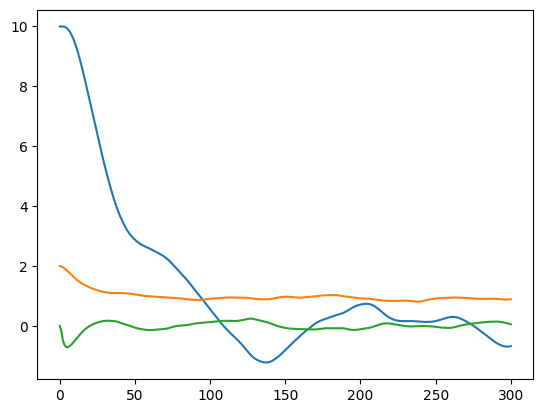

Total Cost:  2198.002927700408


In [ ]:
import matplotlib.pyplot as plt

plt.plot(xhist1[:3,:].T)
plt.show()
cost1 = cost(xhist1[:6,:],uhist1, x_ref, Q, R)

In [13]:
from pathlib import Path
import mujoco
import mujoco.viewer
import time
def simulate(xhist):
    model_name = f"scene"
    model_path = Path("mujoco_models/skydio_x2") / (str(model_name) + str(".xml"))
        # Load the model and data
    model = mujoco.MjModel.from_xml_path(str(model_path.absolute()))

    data = mujoco.MjData(model)
    data.qpos[1] = xhist[0,0]
    data.qpos[2] = xhist[1,0]
    data.qpos[4] = xhist[2,0]
    i = 0
    start_time = time.time()
    with mujoco.viewer.launch_passive(model, data, show_left_ui=False, show_right_ui=False) as viewer:
        viewer.cam.azimuth = 140
        viewer.cam.elevation = -20
        viewer.cam.distance =  8
        viewer.cam.lookat = np.array([1.0 , -0.8 , 1.1])
        while viewer.is_running():
            if i < Nt-1:
                i+=1
            step_start = time.time()
            first_time = time.time()

            # mj_step can be replaced with code that also evaluates
            # a policy and applies a control signal before stepping the physics.
            # input("wait")
            mujoco.mj_step(model, data)
            
            data.qpos[0] = 0
            data.qpos[1] = xhist[0,i]
            data.qpos[2] = xhist[1,i]
            data.qpos[4] = xhist[2,i]
            viewer.sync()
            time_until_next_step = 0.05 - (time.time() - step_start)
            if time_until_next_step > 0:
                # print(time_until_next_step)
                time.sleep(time_until_next_step)
            # Pick up changes to the physics state, apply perturbations, update options from GUI.
simulate(xhist1)

## LQR accounting for the wind dynamics model
Now we account for the wind. The punchline here is that we still ignore the fact that the wind is random - according to our LQR, it is deterministic. BUT, it turns out that this extra knowledge allows the controller to be more robust to all wind that obeys similar dynamics. 

In [14]:
A = approx_fprime(x_hover, A_func, np.sqrt(np.finfo(float).eps))
B = approx_fprime(u_hover, B_func, np.sqrt(np.finfo(float).eps))

# Time settings
Nx = 8  # number of states

# Cost weights
Q = np.eye(Nx)
Q[2,2] = 100.0
R = 0.01 * np.eye(Nu)

# LQR Hover Controller
K, P, E = control.dlqr(A, B, Q, R)

# Closed-loop simulation
def closed_loop_wind(x0, controller, N):
    xhist = np.zeros((len(x0), N))
    u0 = controller(0, x0[:])
    uhist = np.zeros((len(u0), N-1))
    uhist[:, 0] = u0
    xhist[:, 0] = x0
    
    for k in range(N-1):
        v = np.random.normal(0, 1, 2)
        uk = controller(k, xhist[:, k])
        uhist[:, k] = uk #np.clip(uk, umin, umax)  # enforce control limits
        xhist[:, k+1] = quad_dynamics_rk4(xhist[:, k], uhist[:, k], v)
    
    return xhist, uhist

# Reference and initial state
x_ref = np.array([0.0, 1.0, 0, 0, 0, 0, 0, 0])
x0 = np.array([10.0, 2.0, 0.0, 0, 0, 0, 0, 0])

# Simulate closed-loop responses
xhist2, uhist2 = closed_loop_wind(x0, lambda t, x: lqr_controller(t, x, K, x_ref), Nt)
# xhist2, uhist2 = closed_loop(x0, lambda t, x: mpc_controller(t, x, x_ref), Nt)

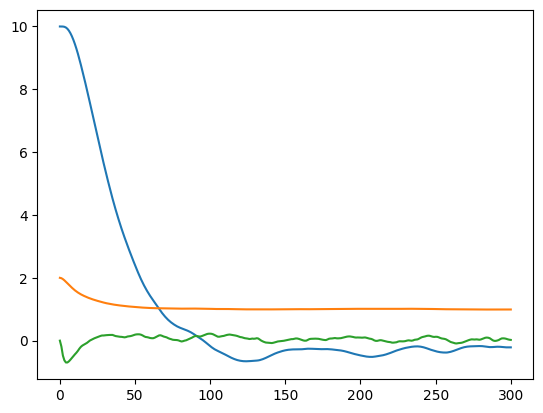

Total Cost:  2046.9464905542131


In [15]:
import matplotlib.pyplot as plt
# plt.plot(xhist2[:,:].T)
# plt.show()

plt.plot(xhist2[:3,:].T)
plt.show()
cost2 = cost(xhist2[:6,:], uhist2, x_ref[:6], Q[:6,:6], R)


In [16]:
simulate(xhist2)